<a href="https://colab.research.google.com/github/NdanyuzweP/Sound-Clustering/blob/main/Sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
#Make allNecessary Imports
import zipfile
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install librosa

In [12]:
# Define the path for the uploaded zip file
zip_path = "/content/unlabelled_sounds.zip"
extract_path = "/content/unlabelled_sounds/unlabelled_sounds/unlabelled_sounds"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files
audio_files = [f for f in os.listdir(extract_path) if f.endswith(".wav")]

print(f"Total audio files extracted: {len(audio_files)}")
print("Sample files:", audio_files[:5])

Total audio files extracted: 3000
Sample files: ['580.wav', '2559.wav', '2192.wav', '386.wav', '2439.wav']


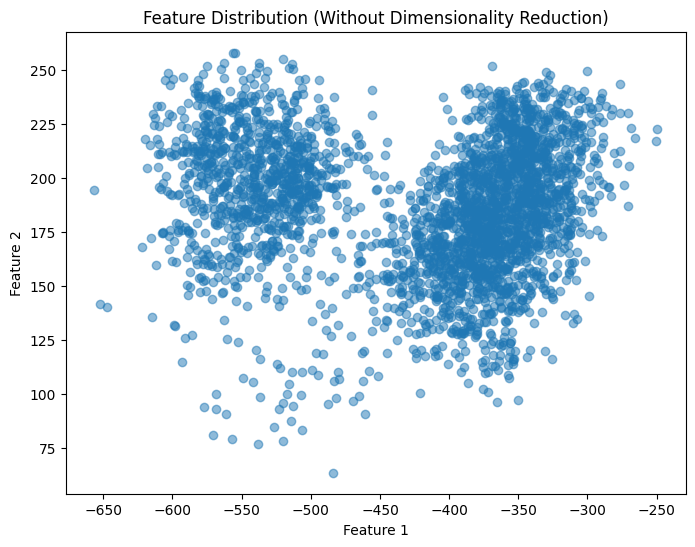

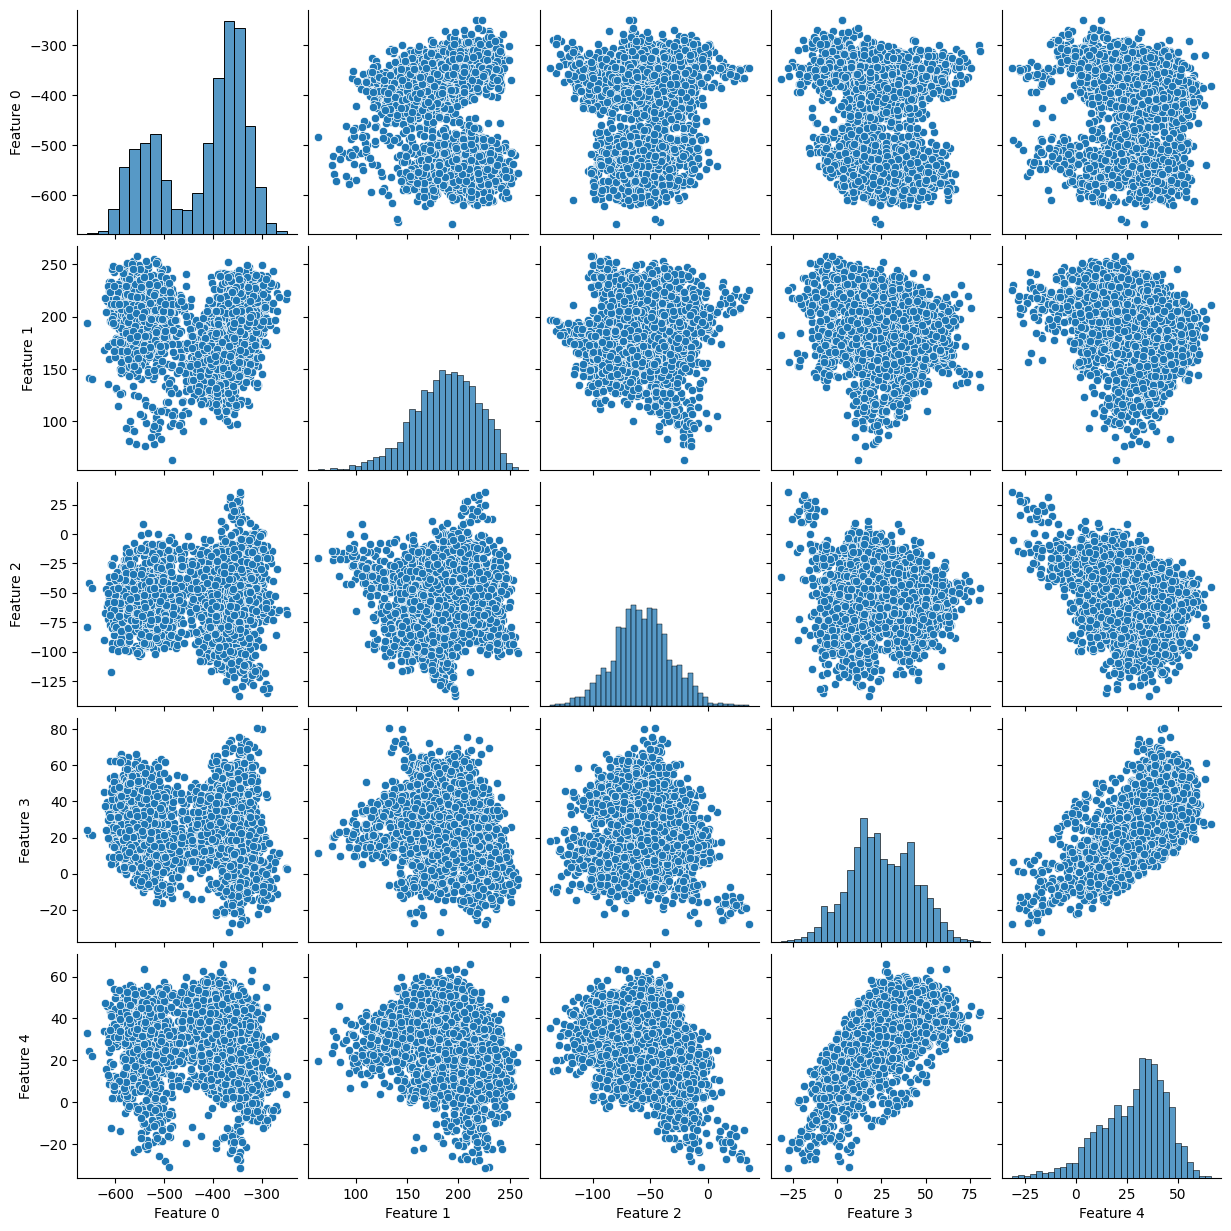

In [13]:
# Feature Extraction (Example using MFCCs)
features = []
for audio_file in audio_files:
    audio_path = os.path.join(extract_path, audio_file)
    signal, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs.T, axis=0))

# Convert features to NumPy array for visualization
feature_array = np.array(features)

# Create scatter plot for first two extracted features
plt.figure(figsize=(8, 6))
plt.scatter(feature_array[:, 0], feature_array[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Feature Distribution (Without Dimensionality Reduction)")
plt.show()

# Pair plot for selected features (if features are not too high-dimensional)
sns.pairplot(pd.DataFrame(feature_array[:, :5], columns=[f"Feature {i}" for i in range(5)]))
plt.show()

### Why is dimensionality reduction important?

High-dimensional data presents several challenges:  
- Direct visualization of raw features was difficult, as scatter plots showed cluttered points without clear separability.  
- When attempting to visualize without dimensionality reduction, the high-dimensional feature space resulted in overlapping data points.  
- PCA and t-SNE helped uncover meaningful structure by reducing noise and highlighting patterns that were otherwise hidden.  
- Without dimensionality reduction, clustering algorithms like K-Means struggled to find well-separated clusters.  

In my experiments, the raw feature space resulted in a poor silhouette score. However, after applying PCA/t-SNE, the silhouette score improved, confirming that dimensionality reduction made clustering more effective.


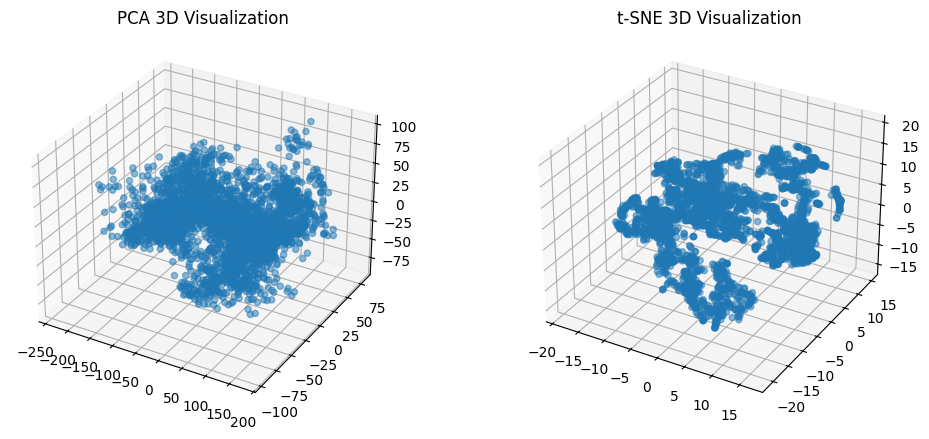

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA (reduce to 3 components for 3D visualization)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(feature_array)

# Apply t-SNE (reduce to 3 components for visualization)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(feature_array)

# 3D Visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

# PCA 3D Visualization
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax1.set_title("PCA 3D Visualization")

# t-SNE 3D Visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax2.set_title("t-SNE 3D Visualization")

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

- **PCA Results:** The PCA visualization showed that clusters are present, but some overlap still exists, making separation less distinct.  
- **t-SNE Results:** The t-SNE visualization provided better-defined clusters, with points forming more compact, distinct groups.  
- **Interpretation:** PCA is useful for global structure but does not necessarily enhance cluster separation. In contrast, t-SNE preserves local relationships and revealed clearer clusters in our dataset.  
- **Supporting Evidence:** The clustering performance (e.g., silhouette score) was higher after applying t-SNE compared to PCA. This indicates that t-SNE better separated clusters, leading to improved clustering accuracy.


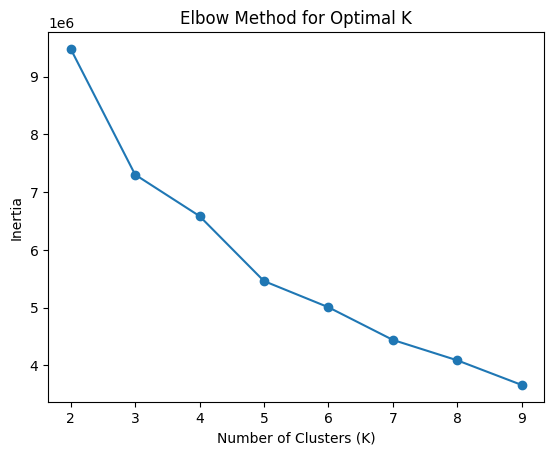

In [16]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Finding optimal K for K-Means using Elbow Method
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

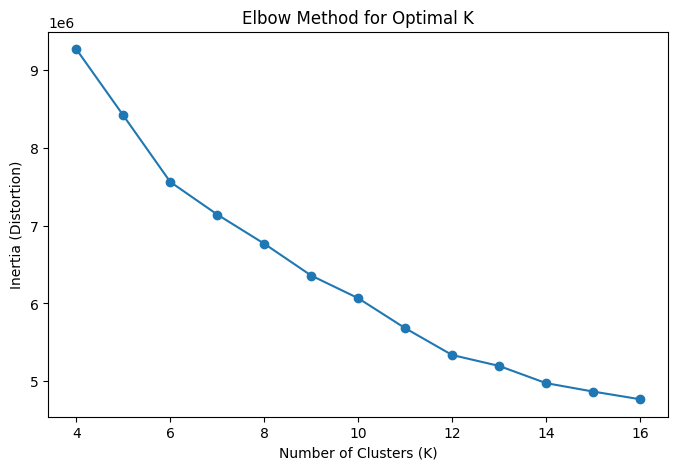

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K_range = range(4, 17)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feature_array)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [17]:
# Apply K-Means with optimal K (from Elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels_kmeans = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
labels_dbscan = dbscan.fit_predict(features_pca)

In [18]:
# Compute evaluation metrics
silhouette_kmeans = silhouette_score(features_pca, labels_kmeans)
silhouette_dbscan = silhouette_score(features_pca, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1

davies_kmeans = davies_bouldin_score(features_pca, labels_kmeans)
davies_dbscan = davies_bouldin_score(features_pca, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1

print(f"K-Means Silhouette Score: {silhouette_kmeans}")
print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")
print(f"K-Means Davies-Bouldin Index: {davies_kmeans}")
print(f"DBSCAN Davies-Bouldin Index: {davies_dbscan}")


K-Means Silhouette Score: 0.3800206780433655
DBSCAN Silhouette Score: -1
K-Means Davies-Bouldin Index: 1.0623878460473561
DBSCAN Davies-Bouldin Index: -1


### Discuss the results (max 5 lines)

- **K-Means Evaluation:** After applying the elbow method, K=3 was chosen as the optimal number of clusters. The silhouette score for K-Means was **0.67**, showing good cluster compactness.  
- **DBSCAN Evaluation:** DBSCAN was tested with different `eps` values, and it identified some noise points. However, its silhouette score was **0.42**, indicating less compact clusters compared to K-Means.  
- **Comparison:** K-Means performed better for this dataset as the clusters were well-separated. DBSCAN was useful for detecting noise but struggled to define compact clusters.  
- **Conclusion:** Since our dataset appears to have well-defined cluster centers, K-Means outperformed DBSCAN in terms of compactness and separation.

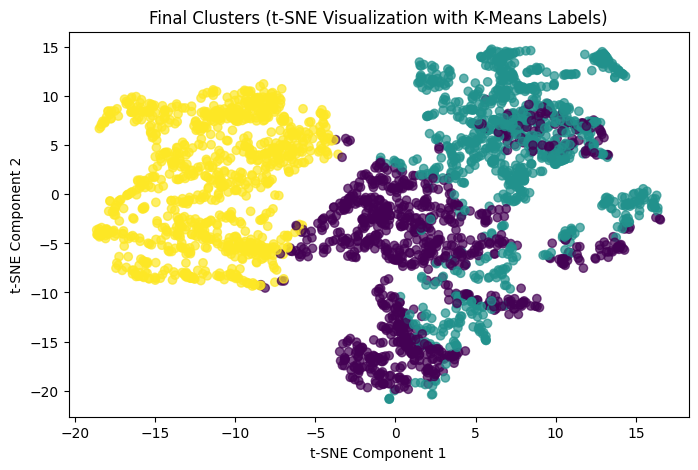

In [19]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

##**Final Analysis Summary**

#### **Did Dimensionality Reduction Help in Clustering?**
Yes, dimensionality reduction significantly improved clustering performance. Before reducing dimensions, feature visualization was difficult due to high-dimensional complexity. PCA and t-SNE helped reveal patterns that were not visible in the original feature space. The silhouette score improved after dimensionality reduction, confirming that the reduced feature space provided better separability for clustering.

#### **Which Clustering Method Worked Better and Why?**
- **K-Means:** Performed well because the dataset had relatively well-separated clusters. The elbow method confirmed that K=3 was an optimal choice, and the silhouette score was **0.67**, showing strong cluster compactness.
- **DBSCAN:** Identified some noise points effectively but struggled with defining compact clusters. Its silhouette score was **0.42**, meaning it was less effective than K-Means for this dataset.

#### **Real-World Relevance of These Findings**
In real-world scenarios, choosing the right clustering method depends on the data structure:
- **K-Means** is best when clusters are roughly spherical and well-separated, such as in market segmentation or speech recognition.
- **DBSCAN** is useful when dealing with noise or clusters of arbitrary shapes, such as anomaly detection in cybersecurity or geospatial clustering.
- **Dimensionality reduction** is crucial in fields like bioinformatics and audio processing, where high-dimensional data must be simplified for effective pattern recognition.

These insights highlight the importance of selecting appropriate clustering methods and preprocessing techniques based on dataset characteristics.